In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df, num_fol):
  generate_more_data(df, num_fol)
  aug_df = create_df_more(num_fol)
  new_df = pd.concat([df, aug_df], ignore_index=True)
  return new_df
# make_balance_train(train_df.loc[train_idx])

In [8]:
def min_len_arr(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  return minlenarr
# print(min_len_arr(train_df.loc[train_idx]))

def generate_more_data(df, num_fol):
    gene = ImageDataGenerator(brightness_range=[0.2,2.0],vertical_flip=True,shear_range=20)
    len_disea = min_len_arr(df)
    print(len_disea)
    max_disea = max(len_disea)
#     print(max_disea)
    for i in type_disea:
        num_of_disea = len_disea[type_disea.index(i)]
        cur_path = os.path.join(f'/kaggle/working/more_img{num_fol}',i)
        create_img = gene.flow_from_dataframe(df.loc[df['labels']==i], x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=1, save_to_dir=cur_path, save_format='jpg')
        if i == type_disea[len_disea.index(max_disea)]: pass
        else:
            for j in range(0, max_disea-num_of_disea):
              hh = next(create_img)       
# generate_more_data(train_df.loc[train_idx],1)

def create_df_more(num_fol):
  filepaths, labels = [],[]
  data_path = f'/kaggle/working/more_img{num_fol}'
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
#   print(df)
  return df

In [9]:
def create_fol(n):
  os.makedirs(f'/kaggle/working/more_img{n}', exist_ok=True)
  for i in type_disea:
    os.makedirs(os.path.join(f'/kaggle/working/more_img{n}', i), exist_ok=True)

[111, 65, 118, 124]
Found 111 validated image filenames belonging to 1 classes.
Found 65 validated image filenames belonging to 1 classes.
Found 118 validated image filenames belonging to 1 classes.
Found 124 validated image filenames belonging to 1 classes.
Found 496 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726986531.878494     101 service.cc:145] XLA service 0x7e63f4027930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726986531.878571     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726986629.890742     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 298s 10s/step - accuracy: 0.4961 - loss: 1.3066 - val_accuracy: 0.6095 - val_loss: 1.5776
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9411 - loss: 0.1724 - val_accuracy: 0.4571 - val_loss: 1.8844
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9824 - loss: 0.0740 - val_accuracy: 0.7048 - val_loss: 1.1599
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9912 - loss: 0.0279 - val_accuracy: 0.7905 - val_loss: 0.8636
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9899 - loss: 0.0382 - val_accuracy: 0.8381 - val_loss: 0.6534
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9878 - loss: 0.0211 - val_accuracy: 0.9429 - val_loss: 0.1726
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9429 - val_loss: 0.1292
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9970 - loss: 0.0074 - val_accuracy: 0.9619 - val_loss: 0.1077
E

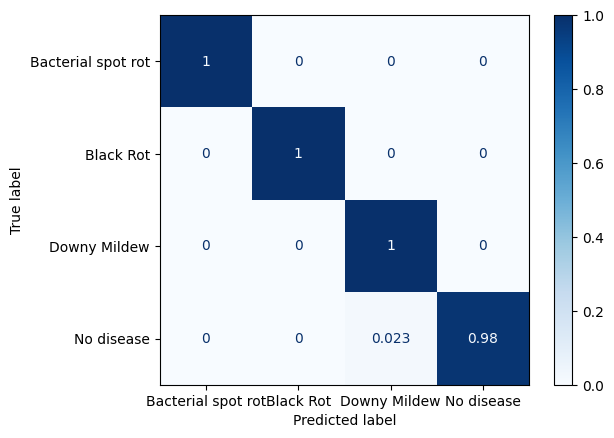

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      0.98      0.99        43

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[107, 67, 112, 132]
Found 107 validated image filenames belonging to 1 classes.
Found 67 validated image filenames belonging to 1 classes.
Found 112 validated image filenames belonging to 1 classes.
Found 132 validated image filenames belonging to 1 classes.
Found 528 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step - accuracy: 0.5939 - loss: 1.1072 - val_accuracy: 0.6381 - val_loss: 1.5712
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9489 - loss: 0.1419 - val_accuracy: 0.7238 - val_loss: 1.0918
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9894 - loss: 0.0475 - val_accuracy: 0.8286 - val_loss: 0.6079
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9971 - loss: 0.0135 - val_accuracy: 0.8762 - val_loss: 0.3833
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9975 - loss: 0.0114 - val_accuracy: 0.9524 - val_loss: 0.2384
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9990 - loss: 0.0088 - val_accuracy: 0.9524 - val_loss: 0.1708
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9986 - loss: 0.0073 - val_accuracy: 0.9524 - val_loss: 0.1658
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9714 - val_loss: 0.1613
Ep

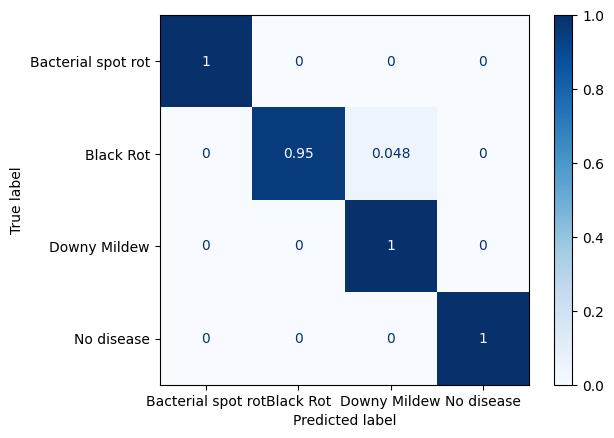

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[120, 56, 103, 139]
Found 120 validated image filenames belonging to 1 classes.
Found 56 validated image filenames belonging to 1 classes.
Found 103 validated image filenames belonging to 1 classes.
Found 139 validated image filenames belonging to 1 classes.
Found 556 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.5995 - loss: 1.0527 - val_accuracy: 0.6095 - val_loss: 1.1695
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9577 - loss: 0.1205 - val_accuracy: 0.8095 - val_loss: 0.5386
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9837 - loss: 0.0565 - val_accuracy: 0.8762 - val_loss: 0.3753
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9902 - loss: 0.0370 - val_accuracy: 0.8857 - val_loss: 0.3764
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9908 - loss: 0.0366 - val_accuracy: 0.9238 - val_loss: 0.2795
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9911 - loss: 0.0247 - val_accuracy: 0.9619 - val_loss: 0.1920
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9996 - loss: 0.0079 - val_accuracy: 0.9714 - val_loss: 0.1330
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9966 - loss: 0.0051 - val_accuracy: 0.9714 - val_loss: 0.1202
Ep

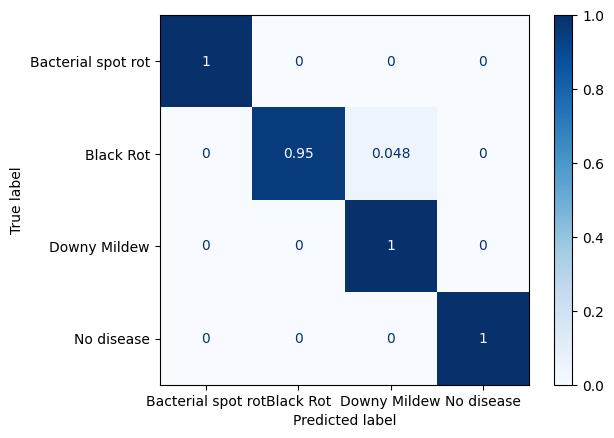

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[110, 63, 112, 134]
Found 110 validated image filenames belonging to 1 classes.
Found 63 validated image filenames belonging to 1 classes.
Found 112 validated image filenames belonging to 1 classes.
Found 134 validated image filenames belonging to 1 classes.
Found 536 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 285s 9s/step - accuracy: 0.5727 - loss: 1.0953 - val_accuracy: 0.3173 - val_loss: 2.3269
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9668 - loss: 0.1168 - val_accuracy: 0.6250 - val_loss: 1.0815
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9594 - loss: 0.0928 - val_accuracy: 0.7596 - val_loss: 0.6090
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.9135 - val_loss: 0.1747
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9944 - loss: 0.0157 - val_accuracy: 0.9615 - val_loss: 0.0655
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9939 - loss: 0.0177 - val_accuracy: 0.9808 - val_loss: 0.0624
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9904 - val_loss: 0.0453
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9992 - loss: 0.0085 - val_accuracy: 0.9904 - val_loss: 0.0297
Ep

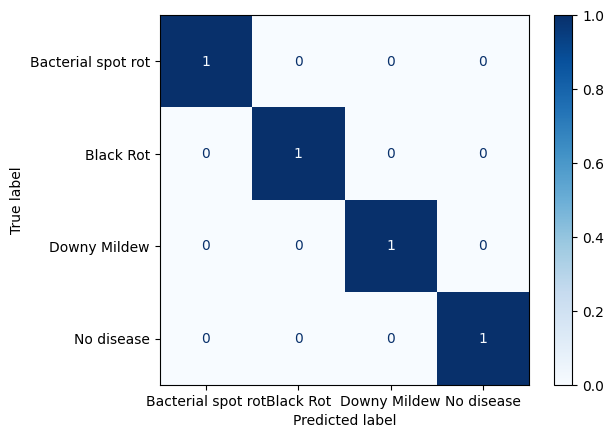

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[116, 69, 107, 127]
Found 116 validated image filenames belonging to 1 classes.
Found 69 validated image filenames belonging to 1 classes.
Found 107 validated image filenames belonging to 1 classes.
Found 127 validated image filenames belonging to 1 classes.
Found 508 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 281s 9s/step - accuracy: 0.5865 - loss: 1.1467 - val_accuracy: 0.5769 - val_loss: 1.2961
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9529 - loss: 0.1640 - val_accuracy: 0.7500 - val_loss: 0.8390
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9889 - loss: 0.0454 - val_accuracy: 0.8558 - val_loss: 0.4140
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9948 - loss: 0.0257 - val_accuracy: 0.9231 - val_loss: 0.2508
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9975 - loss: 0.0151 - val_accuracy: 0.9231 - val_loss: 0.2913
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9995 - loss: 0.0102 - val_accuracy: 0.9327 - val_loss: 0.1409
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9981 - loss: 0.0181 - val_accuracy: 0.9712 - val_loss: 0.0769
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9927 - loss: 0.0240 - val_accuracy: 0.9808 - val_loss: 0.0682
Ep

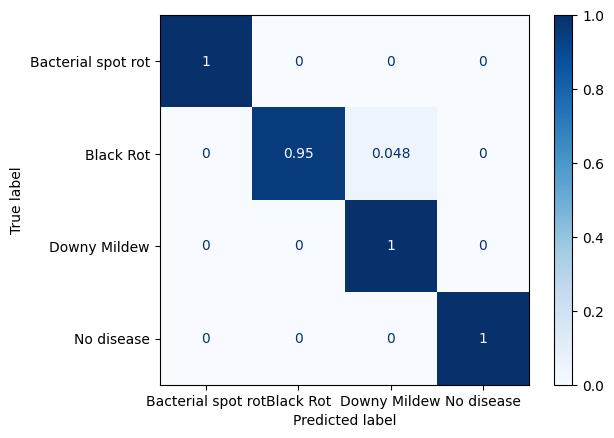

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133



In [10]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])

epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  create_fol(i) 
  a = make_balance_train(train_df.loc[train_idx], i)
  b = train_df.loc[valid_idx]
  train = ImageDataGenerator().flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)